# Weather image classification with convolutional neural networks

This examples covers training of a deep neural network that analyses highdimensional inputs (an image file) to produce a univariate output (weather type).

The image data are passed as a regular jpg photo, that could have been taken by a digital camera or phone, or extracted from a webcam feed or a dashcam.

Data augmentation is used to artificially increase the number of images in the training data.

A deep neural network is constructed with `Sequential`, but new layer types are used, namely
- convolutional layer
- pooling layer
- dropout layer

The example is losely based on the following article https://urvog.medium.com/weather-image-classification-with-keras-4eee9468ff2f and the images were downloaded from https://data.mendeley.com/datasets/4drtyfjtfy/1 .

## Prerequisites

The following packages will be used in this tutorial. You might have to install them first.

In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

## Data preprocessing

We have our data in the directory `weather-img` with the specific directory structure expected by the model fitting function later.

The directory `weather-img` has subdirectories `test`, `train`, `validate`, each of which has subdirectories corresponding to the true labels of the images it contains (`cloudy`, `rain`, `shine`, `sunrise`).

```
weather-img-clean
├── test
│   ├── cloudy
│   │   ├── 11.jpg
│   │   ├── ...
│   │   └── 57.jpg
│   ├── rain
│   │   ├── 107.jpg
│   │   ├── ...
│   │   └── 91.jpg
│   ├── shine
│   │   ├── 131.jpg
│   │   ├── ...
│   │   └── 9.jpg
│   └── sunrise
│       ├── 121.jpg
│       ├── ...
│       └── 90.jpg
├── train
│   ├── cloudy
│   │   ├── 104.jpg
│   │   ├── ...
│   │   └── 95.jpg
│   ├── rain
│   │   ├── 108.jpg
│   │   ├── ...
│   │   └── 96.jpg
│   ├── shine
│   │   ├── 104.jpg
│   │   ├── ...
│   │   └── 95.jpg
│   └── sunrise
│       ├── 101.jpg
│       ├── ...
│       └── 98.jpg
└── validate
    ├── cloudy
    │   ├── 119.jpg
    │   ├── ...
    │   └── 84.jpg
    ├── rain
    │   ├── 112.jpg
    │   ├── ...
    │   └── 92.jpg
    ├── shine
    │   ├── 10.jpg
    │   ├── ...
    │   └── 82.jpg
    └── sunrise
        ├── 137.jpg
        ├── ...
        └── 99.jpg

```

## Display some images

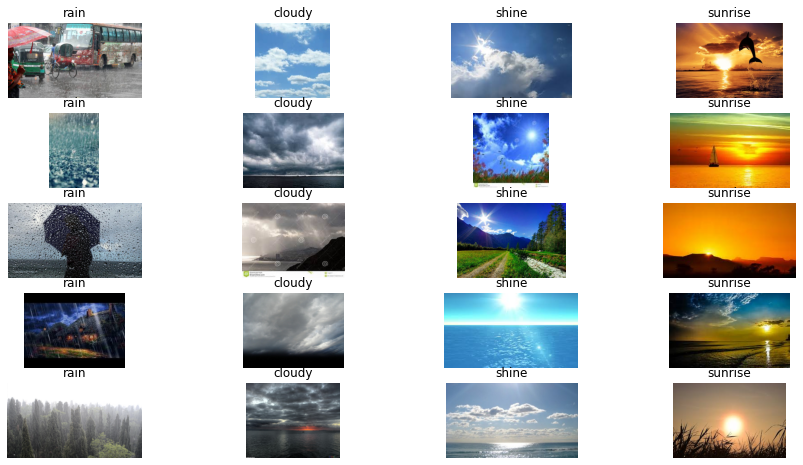

In [2]:
data_dir = 'weather-img'
fig = plt.figure(figsize=(15, 8))
for ii in range(4):
    for jj in range(5):
        tt = ["rain", "cloudy", "shine", "sunrise"][ii]
        ff = os.listdir(data_dir + "/test/" + tt)[jj]
        im = Image.open(data_dir + "/test/" + tt + "/" + ff)
        im_array = np.asarray(im)
        fig.add_subplot(5, 4, (jj*4)+ii+1)
        plt.imshow(im_array)
        plt.axis('off')
        plt.title(tt)
plt.show()

Our neural network will be trained to "look" at an image, and infer the correct weather type ("rain", "cloudy", "shine", or "sunrise").

## Data augmentation

We have 1125 files in the directory with examples for four different groups. If we just went ahead with training on these files, we would find that having less than 300 image files per label is not enough to fit a neural network that can reliable detect weather patterns in new, yet unseen, images.

**Data augmentation** is a method to **artificially increase the number of training images** in a data set by randomly modifying existing training data. The function `ImageDataGenerator` randomly rotates, zooms, shears, and flips images to create altered versions that can be added to the training data set.
See here for a detailed explanation and an example: https://studymachinelearning.com/keras-imagedatagenerator/

In [4]:
# create the data augmentation functions, only the training data will be mutated. 
# the validation and test data will only be rescaled so that the numerical values 
# in the image arrays are comparable.
aug_train = ImageDataGenerator(
    rotation_range=30,
    zoom_range = 0.4,
    shear_range = 0.4,
    horizontal_flip = True,
    rescale=1.0 / 255.0
)
aug_val = ImageDataGenerator(
    rescale = 1.0 / 255.0)

We illustrate the training data generator by generating 9 versions of the same image using the `ImageDataGenerator.flow()` method. The method takes an array of images (in numpy array format) and a target directory. The `flow` method returns an iterator object `im_gen` that has to be called with `im_gen.next()` to generate an image and save it inside the target directory. After generating 9 mutated versions of the same image, we display them:

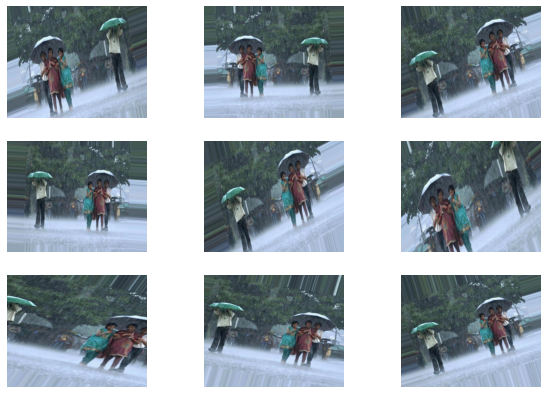

In [5]:
# create a temporary directory to store the generated images
tmp_aug_dir = "tmp_aug_dir"
shutil.rmtree(tmp_aug_dir, ignore_errors=True)
os.mkdir(tmp_aug_dir)

# the original image to be transformed
img = Image.open("weather-img/test/rain/14.jpg") 
im_arr = np.asarray(img)
im_arr = np.expand_dims(im_arr, axis=0)

# create the iterator and "execute" it 9 times
im_gen = aug_train.flow(im_arr, batch_size=1, save_to_dir=tmp_aug_dir, save_format="jpg")
for ii in range(9):
    im_gen.next()
    
# display the generated images
fig = plt.figure(figsize=(10, 7))
for ii in range(9):
    ff_ = os.listdir(tmp_aug_dir)[ii]
    im_ = Image.open(tmp_aug_dir + "/" + ff_)
    im_arr_ = np.asarray(im_)
    fig.add_subplot(3, 3, ii+1)
    plt.imshow(im_arr_)
    plt.axis('off')
plt.show()
# remove the directory that contained the generated images
shutil.rmtree(tmp_aug_dir, ignore_errors=True) 

Now we create the actual training and validation data generators that will later be passed to `model.fit` to generate training data.

In [6]:
IMG_SIZE = 100
BATCH_SIZE = 32
gen_train = aug_train.flow_from_directory(
    data_dir + "/train/",
    target_size = [IMG_SIZE, IMG_SIZE],
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)
gen_val = aug_val.flow_from_directory(
    data_dir + "/validate/",
    target_size = [IMG_SIZE, IMG_SIZE],
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)

Found 811 images belonging to 4 classes.
Found 147 images belonging to 4 classes.


## Build the model

### Layers and loss function

We train a deep convolutional neural network for this image classification task. The network architecture consists of 2 **convolutional layers**, followed by a **Max-Pooling layer**. The output of the max-pooling is **flattened** (transformed from 2d to 1d) and passed on to a **densely connected** layer. A **Dropout layer** is used to reduce the risk of overfitting, and at last the output layer is a densely connected layer with **4 outputs**, because there are 4 possible classes. The **softmax activation function** makes sure that the 4 outputs are non-negative numbers that sum to one, and can thus be interpreted as probabilities assigned to the four classes.

In [8]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

We compile the model with the standard "Adam" optimizer with a slow learning rate. The loss function is the **categorical cross entropy** which quantifies how well the array of 4 probabilities predicts the true class label of an input image. 

In [9]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 200)               8000200   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                        

This neural network has over 8 million trainable parameters! Let's see how the fitting goes.

## Training

We use the `model.fit` method, but we save the output in the variable `h` to be able to inspect the learning history in more detail.

In [10]:
h = model.fit(gen_train, validation_data=gen_val, epochs=20)

Epoch 1/20
26/26 [==============================] - 13s 481ms/step - loss: 1.4244 - accuracy: 0.5512 - val_loss: 0.7995 - val_accuracy: 0.5782
Epoch 2/20
26/26 [==============================] - 11s 438ms/step - loss: 0.8087 - accuracy: 0.6461 - val_loss: 0.6611 - val_accuracy: 0.7687
Epoch 3/20
26/26 [==============================] - 12s 470ms/step - loss: 0.6322 - accuracy: 0.7670 - val_loss: 0.3847 - val_accuracy: 0.8912
Epoch 4/20
26/26 [==============================] - 12s 459ms/step - loss: 0.5001 - accuracy: 0.8089 - val_loss: 0.3529 - val_accuracy: 0.8912
Epoch 5/20
26/26 [==============================] - 12s 444ms/step - loss: 0.4999 - accuracy: 0.7904 - val_loss: 0.3540 - val_accuracy: 0.8912
Epoch 6/20
26/26 [==============================] - 12s 452ms/step - loss: 0.4642 - accuracy: 0.8076 - val_loss: 0.3058 - val_accuracy: 0.9048
Epoch 7/20
26/26 [==============================] - 12s 454ms/step - loss: 0.4082 - accuracy: 0.8446 - val_loss: 0.2707 - val_accuracy: 0.9048

In [9]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

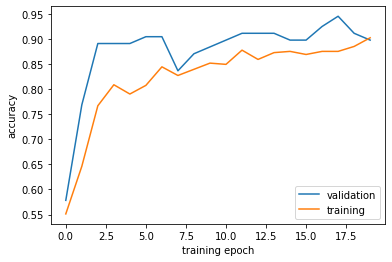

In [11]:
plt.plot(h.history["val_accuracy"], label='validation')
plt.plot(h.history["accuracy"], label='training')
plt.legend()
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.show()

## Model predictions on test data

To generate test data that is compatible with the input layer of our trained model, we create another generator with the same settings as the validation `ImageDataGenerator`, but that gets data from the `test/` directory. A call to its `next()` method generates the test data and also the corresponding labels.

In [12]:
gen_test = aug_val.flow_from_directory(
    data_dir + "/test/",
    target_size = [IMG_SIZE, IMG_SIZE],
    batch_size = BATCH_SIZE,
    class_mode='categorical'
)
tt = gen_test.next()
test_input = tt[0]
test_labels = tt[1]

Found 167 images belonging to 4 classes.


Below we display a few of the test images with their correct labels.

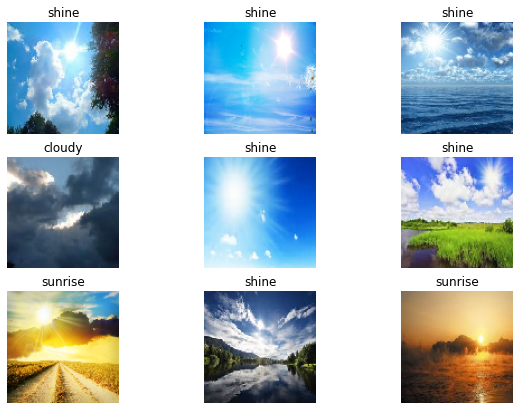

In [13]:
label_str = np.array(['cloudy', 'rain', 'shine', 'sunrise'])
sampls = np.random.choice(len(test_input), replace=False, size=9)
fig = plt.figure(figsize=(10, 7))
for ii in range(9):
    jj = sampls[ii]
    fig.add_subplot(3, 3, ii+1)
    plt.imshow(test_input[jj])
    plt.title(label_str[test_labels[jj] == 1][0])
    plt.axis('off')
plt.show()

We pipe the test images produced by the image generator through our trained model.

In [14]:
pred = model(test_input)

The result is a tensor with 4 columns, which contain the predicted probabilities for each of the 4 categories:

In [15]:
pred[:5]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[9.8302025e-01, 1.0821252e-03, 7.8742476e-03, 8.0234371e-03],
       [1.1431154e-02, 8.6694177e-05, 9.8761547e-01, 8.6673553e-04],
       [5.9416449e-01, 3.4969634e-01, 4.6186093e-02, 9.9531198e-03],
       [7.4621779e-01, 1.2219218e-02, 3.9640699e-02, 2.0192233e-01],
       [1.5205069e-01, 1.9527673e-04, 8.4531981e-01, 2.4342260e-03]],
      dtype=float32)>

The following code loops over all test images, displays them along with their predicted and true labels.

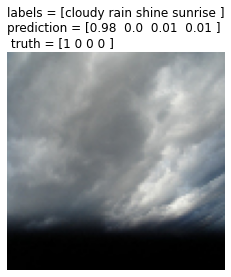

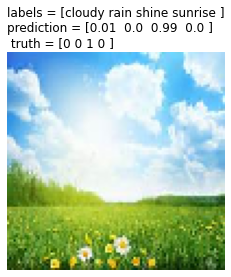

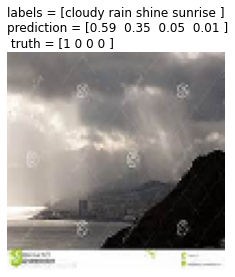

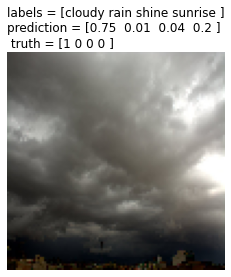

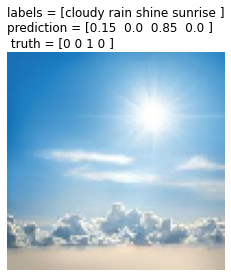

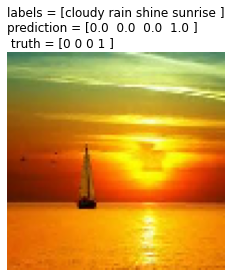

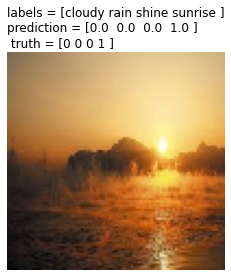

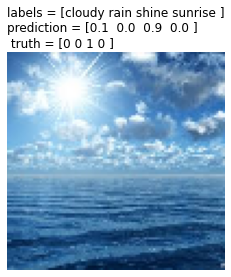

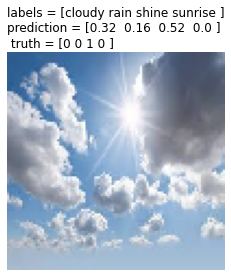

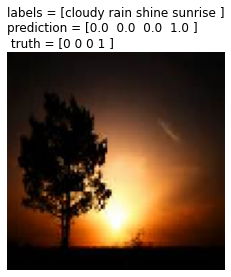

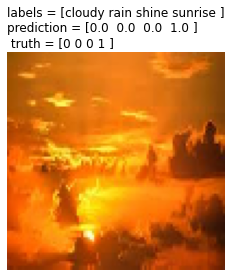

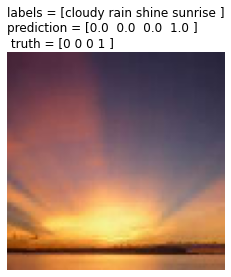

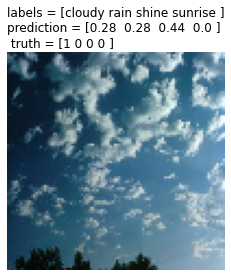

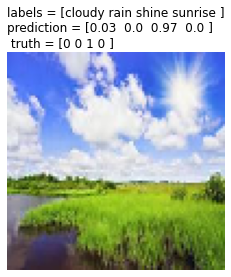

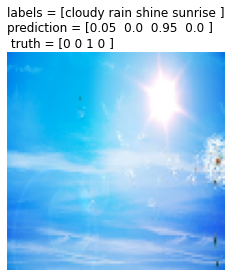

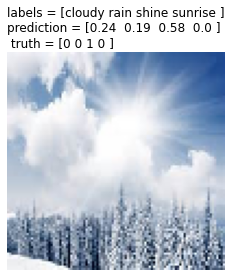

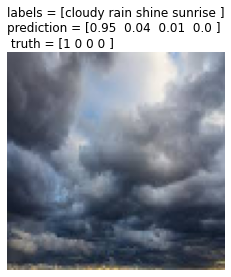

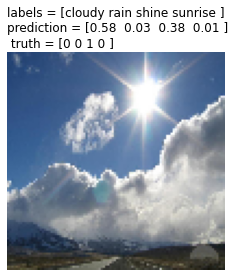

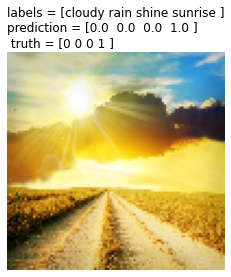

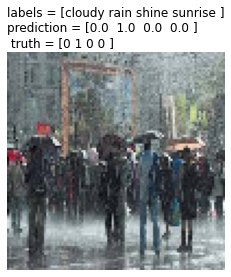

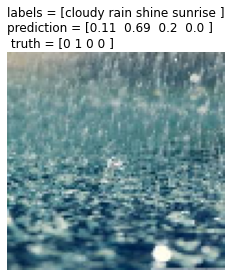

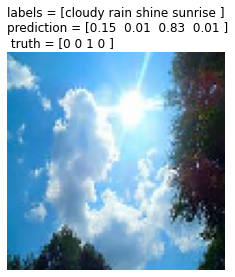

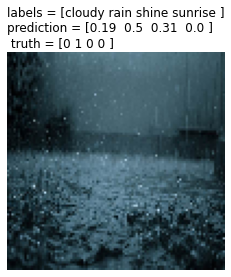

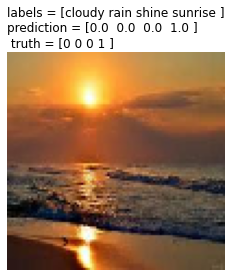

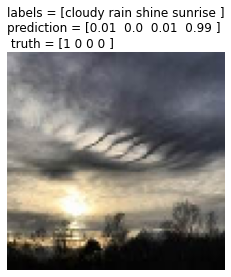

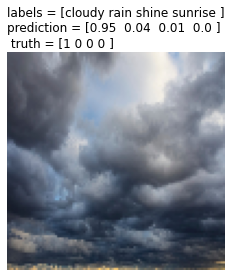

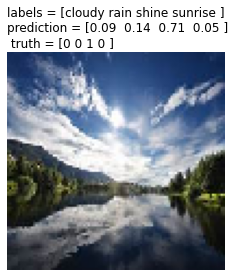

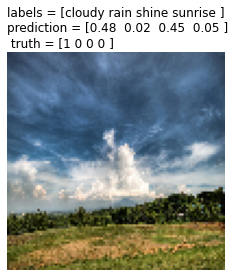

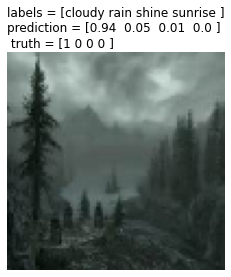

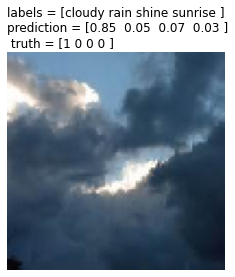

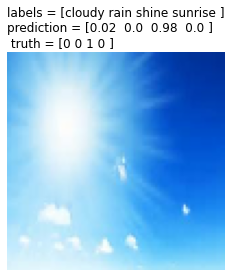

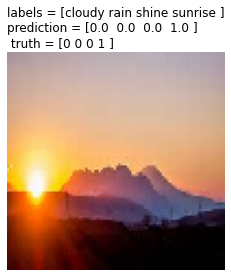

In [16]:
n_test = len(test_input)
labls = "[" + "".join([s + " " for s in label_str]) + "]" 
for ii in range(n_test):
    plt.imshow(test_input[ii])
    true_ii = "[" + "".join([str(int(j)) + " " for j in test_labels[ii]]) + "]"
    pred_ii = "[" + " ".join([str(j) + " " for j in np.round(pred[ii,:], 2)]) + "]"
    plt.title("labels = " + labls + "\nprediction = " + pred_ii + "\n truth = " + true_ii, loc='left')
    plt.axis('off')
    plt.show()

The classification works surprisingly well on the test data. 

More often than not, a high  probability is assigned to the true label. The cases where the prediction is wrong or ambiguous are always cases where a human classifier might also be uncertain or make a mistake (e.g. between "shine" and "sunrise", or between "cloudy" and "rain").
